# Test Affinity and comp algorithm on liquid
- this algorithm is usually fast and accurate
- but it can fail to converge, causing major problems


In [1]:
import numpy as np
from os import path
import pandas as pd
import scipy.optimize as opt
from scipy import optimize
import scipy.linalg as lin
import scipy as sp
import sys
import sympy as sym

from collections import OrderedDict as odict

import matplotlib.pyplot as plt

import sunkenhull as hull
from thermoengine.model import GeoCompDB, SysComp

Required ENKI modules (ignore the error message from Rubicon running under Python 3.6+)

In [2]:
from thermoengine import coder, core, phases, model, equilibrate

In [3]:
modelDB = model.Database(database='Berman')

## Assume MORB Bulk Composition


In [4]:
compDB = GeoCompDB()

In [5]:
sysID = 'MORB_primitive'
CO2='none'
# H2O='none'
H2O = 'input'
syscomp = compDB.get_syscomp(
    sysID, components='oxides',CO2=CO2,H2O=H2O)
display(syscomp.wt_comp())
display(syscomp.mol_comp('oxides'))

/Users/aswolf/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


SiO2  TiO2  Al2O3  Fe2O3   Cr2O3   FeO  MnO  MgO  NiO  CoO  \
MORB_primitive  48.68  1.01  17.64   0.89  0.0425  7.59    0  9.1    0    0   

                  CaO  Na2O   K2O  P2O5  H2O  
MORB_primitive  12.45  2.65  0.03  0.08  0.2

SiO2      TiO2     Al2O3     Fe2O3    Cr2O3       FeO  \
MORB_primitive  0.810195  0.012641  0.173007  0.005573  0.00028  0.105642   

                MnO       MgO  NiO  CoO       CaO      Na2O       K2O  \
MORB_primitive  0.0  0.225782  0.0  0.0  0.222007  0.042756  0.000318   

                    P2O5       H2O  
MORB_primitive  0.000564  0.011102

In [6]:
elem_comp = syscomp.mol_comp(components='elems')
sys_elems=elem_comp.columns.values
bulk_comp = elem_comp.values[0]

## P/T conditions selected to involve many phases present

In [7]:
T = 1175+273.15
T= 1600+273
P = 1e3

## Initialize assemblage w/ pure liquid
- if omnicomponent phase is present this will produce good initial guess for chempot
- assume pure liquid for MORB composition system


In [8]:
mol_oxides=syscomp.mol_comp(components='oxides')
mol_oxides['CO2']=0
mol_oxides.values.squeeze()

array([8.10195009e-01, 1.26409909e-02, 1.73006851e-01, 5.57322148e-03,
       2.79623292e-04, 1.05642036e-01, 0.00000000e+00, 2.25781800e-01,
       0.00000000e+00, 0.00000000e+00, 2.22006655e-01, 4.27564589e-02,
       3.18459843e-04, 5.63600483e-04, 1.11017363e-02, 0.00000000e+00])

In [9]:
liq = modelDB.get_phase('Liq')

In [10]:
mol_endmem = liq.calc_endmember_comp(mol_oxides.values.squeeze(),method='intrinsic')
mol_endmem/=mol_endmem.sum()

In [11]:
chempot = liq.chem_potential(T, P,  mol=mol_endmem).squeeze()

In [12]:
dG = liq.gibbs_energy(T, P, mol=mol_endmem)-chempot.dot(mol_endmem)
dG

-0.058901326498016715

In [13]:
# lin.lstsq()

In [14]:
liq_elem_comp = pd.DataFrame(liq.props['element_comp'],index=liq.endmember_names, 
                             columns=SysComp.PERIODIC_ORDER)[sys_elems]
liq_elem_comp


H    O   Na   Mg   Al   Si    P    K   Ca   Ti   Cr   Mn   Fe  \
SiO2       0.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
TiO2       0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
Al2O3      0.0  3.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Fe2O3      0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0   
MgCr2O4    0.0  4.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0   
Fe2SiO4    0.0  4.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0   
MnSi0.5O2  0.0  2.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
Mg2SiO4    0.0  4.0  0.0  2.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
NiSi0.5O2  0.0  2.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
CoSi0.5O2  0.0  2.0  0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
CaSiO3     0.0  3.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
Na2SiO3    0.0  3.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
KAlSiO4    0.0  4.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
Ca3(PO4)2  0.0  8.0  0.0  0.0  0.0  0.0  2.0  0.0  3.0  0.0  0.0  0.0  0.0   
H2O        2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            Co   Ni  
SiO2       0.0  0.0  
TiO2       0.0  0.0  
Al2O3      0.0  0.0  
Fe2O3      0.0  0.0  
MgCr2O4    0.0  0.0  
Fe2SiO4    0.0  0.0  
MnSi0.5O2  0.0  0.0  
Mg2SiO4    0.0  0.0  
NiSi0.5O2  0.0  1.0  
CoSi0.5O2  1.0  0.0  
CaSiO3     0.0  0.0  
Na2SiO3    0.0  0.0  
KAlSiO4    0.0  0.0  
Ca3(PO4)2  0.0  0.0  
H2O        0.0  0.0

## verify that liquid composition calculated correctly

In [15]:
elem_diff = liq_elem_comp.T.dot(mol_endmem)-elem_comp
elem_diff.abs()<1e-10

H      O     Na     Mg     Al     Si      P      K     Ca  \
MORB_primitive  False  False  False  False  False  False  False  False  False   

                   Ti     Cr    Mn     Fe    Co    Ni  
MORB_primitive  False  False  True  False  True  True

In [16]:
chempot_elems = lin.lstsq(liq_elem_comp, chempot)[0]
chempot_elems

array([-160715.12834944, -306405.9350444 , -372909.62567831,
       -463397.65002459, -544089.26767147, -504822.4368305 ,
       -461157.07715078, -484837.49443091, -594546.04194381,
       -614191.16523914, -325857.44280301, -576767.87918505,
       -203510.82413298, -420898.37673387, -359465.59070883])

In [17]:
mu = chempot.copy()
mu[mol_endmem==0]=0
mu

array([-1117634.3069193 , -1227003.03532795, -2007396.34047615,
       -1326239.45339917, -2340736.27580822, -2137467.82527407,
              0.        , -2657241.47705728,        0.        ,
              0.        , -2018586.28390752, -2169859.49332032,
       -2759372.93911049, -5157199.76048822,  -627836.19174328])

In [18]:
noise = .3
# noise=0

In [19]:
X_init = mol_endmem*np.exp(noise*np.random.randn(mu.size))
X_init[X_init<0] = 0
X_init[X_init>1] = 1
X_init[mol_endmem==0] = 0

In [20]:
# X_init /= X_init.sum()

In [21]:
liq.chem_potential(T, P,  mol=X_init).squeeze()

array([-1114773.75082839, -1222447.34173657, -2024269.50098804,
       -1332767.10711346, -2347234.04475437, -2133860.59648038,
       -1442768.28258303, -2658085.06615446, -1230006.11181124,
       -1292629.85366671, -2014735.49687056, -2170923.84001928,
       -2760012.72090325, -5156958.46669537,  -631068.37231103])

## Cold-start legacy version

In [22]:
A0, X0 = liq.affinity_and_comp_legacy(T, P, mu)
print(A0)
logdx = np.log(X0/mol_endmem)
logdx[mol_endmem==0] = 0
logdx

-674.0637873862561


/Users/aswolf/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([-0.01364523, -0.14717773, -0.20365991, -0.09978163,  0.35033438,
       -0.0653423 ,  0.        , -0.06220195,  0.        ,  0.        ,
        0.12692768,  0.49514077,  0.16516519, -0.0191116 , -1.29163162])

In [23]:
A, X = liq.affinity_and_comp(T, P, mu)
print(A)
logdx = np.log(X/mol_endmem)
logdx[mol_endmem==0] = 0
logdx

-0.00019333734686145993


/Users/aswolf/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 7.21488360e-05, -1.67934362e-04, -1.11379636e-04, -1.98271479e-04,
       -6.04221364e-05, -1.37939470e-04,  0.00000000e+00, -1.06723813e-04,
        0.00000000e+00,  0.00000000e+00, -3.07906268e-06,  2.80308547e-04,
        1.75320412e-04, -1.87523284e-04,  2.69991334e-04])

In [24]:
dmu = (liq.chem_potential(T, P, mol=X)-mu).squeeze()
dmu[mu==0]=0
np.dot(dmu, X)

9.600798500840335e-05

## Cold-start converges rapidly

In [25]:
A, X = liq.affinity_and_comp(T, P, mu, debug=True)

Mole fraction mask:  [ 0  1  2  3  4  5  7 10 11 12 13 14]
Computed site multiplicity: 1.0
---
iter:  1 Anew:   -2703.12 Aold:    4951.46 max(logX_diff) : 4.51 
  logdX : -5.05e-01, -6.33e-01, +1.74e+00, +5.17e-01, -1.01e+00, -6.49e-01, +7.60e-02, -6.39e-02, +3.84e+00, +1.90e-01, -1.50e+00, +4.51e+00, 
 dphi : -3.00e+03, -6.10e+03, +3.76e+04, +1.72e+04, -1.70e+04, -6.48e+03, +0.00e+00, +9.12e+03, +0.00e+00, +0.00e+00, +6.40e+03, +7.08e+04, +1.13e+04, -4.73e+04, +8.14e+04, 
---
iter:  2 Anew:    -849.65 Aold:   -2703.12 max(logX_diff) : 1.51 
  logdX : +1.53e-01, -1.70e-01, -2.16e-01, -9.36e-02, -5.24e-01, +2.54e-01, -6.41e-02, +1.77e-01, +2.09e-01, -3.55e-01, -1.18e+00, -1.51e+00, 
 dphi : +3.86e+03, -1.35e+03, -9.10e+03, -5.20e+03, -4.05e+03, +6.99e+03, +0.00e+00, -3.39e+03, +0.00e+00, +0.00e+00, +1.78e+03, -1.29e+03, -9.79e+03, -1.71e+03, -6.23e+04, 
---
iter:  3 Anew:     -66.62 Aold:    -849.65 max(logX_diff) : 0.71 
  logdX : +2.54e-02, +8.08e-02, +1.24e-01, +7.55e-02, -3.89e-01, 

## Warm-start also converges
- roughly same convergence time for cold start and warm start

In [26]:
A, X = liq.affinity_and_comp(T, P, mu, X_init=X_init, debug=True)

Mole fraction mask:  [ 0  1  2  3  4  5  7 10 11 12 13 14]
Computed site multiplicity: 1.0
---
iter:  1 Anew:    -512.90 Aold:    -587.16 max(logX_diff) : 0.55 
  logdX : +1.19e-01, +1.73e-02, -5.45e-01, -1.55e-01, +1.60e-01, +1.08e-01, -6.90e-02, +2.31e-01, +3.47e-01, -1.04e-01, -1.93e-01, +7.33e-03, 
 dphi : +2.20e+03, +2.61e+02, -1.17e+04, -3.16e+03, +2.99e+03, +2.00e+03, +0.00e+00, -1.43e+03, +0.00e+00, +0.00e+00, +4.31e+03, +6.44e+03, -2.13e+03, -3.93e+03, +6.84e+01, 
---
iter:  2 Anew:    -122.02 Aold:    -512.90 max(logX_diff) : 0.28 
  logdX : -8.40e-03, -6.23e-03, +2.79e-01, +6.59e-02, -2.03e-01, -7.88e-03, +3.09e-02, -1.52e-01, -2.68e-01, -2.21e-02, +6.62e-02, -2.36e-02, 
 dphi : -9.84e+02, -5.79e+02, +7.99e+03, +1.55e+03, -5.02e+03, -9.39e+02, +0.00e+00, +4.90e+02, +0.00e+00, +0.00e+00, -4.20e+03, -6.91e+03, -3.89e+02, +1.74e+03, -8.81e+02, 
---
iter:  3 Anew:     -41.45 Aold:    -122.02 max(logX_diff) : 0.19 
  logdX : +1.00e-02, -1.70e-02, -1.50e-01, -2.38e-02, +1.23e-01, 

In [27]:
display(A)
display(X)

-0.00026250057403288805

array([3.75992303e-01, 1.24797564e-02, 1.70485496e-01, 5.50225099e-03,
       2.76010631e-04, 5.21460306e-02, 0.00000000e+00, 1.11307559e-01,
       0.00000000e+00, 0.00000000e+00, 2.17471130e-01, 4.21937541e-02,
       6.28623094e-04, 5.56411460e-04, 1.09606752e-02])

In [28]:
dmu = (liq.chem_potential(T, P, mol=X)-mu).squeeze()
dmu[mu==0]=0
np.dot(dmu, X)

0.0001049243430822494

In [29]:

np.dot(liq.chem_potential(T, P, mol=X)-mu, X)

array([0.00010492])

In [30]:
np.log(X/mol_endmem)[mol_endmem!=0]

/Users/aswolf/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([-4.58403638e-05,  1.21319756e-04,  1.19712562e-04,  1.42280733e-04,
       -4.56765186e-05,  9.71315631e-05,  7.27882803e-05, -3.78571760e-05,
       -2.89814408e-04, -1.53453241e-04,  1.20670728e-04,  1.70617747e-04])

In [31]:
Xdiff = X-mol_endmem
Xdiff_max = np.max(np.abs(Xdiff))
print('max Xdiff = ', Xdiff_max)

max Xdiff =  2.0408033908680956e-05


(0.0, 1.0)

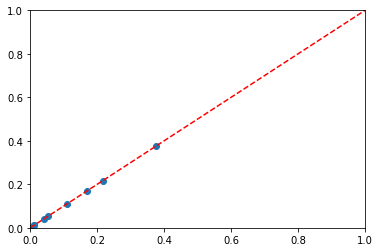

In [32]:
plt.figure()
plt.plot(mol_endmem, X, 'o')
plt.plot([0,1],[0,1], 'r--')
plt.xlim(0,1)
plt.ylim(0,1)

(0.0001, 1)

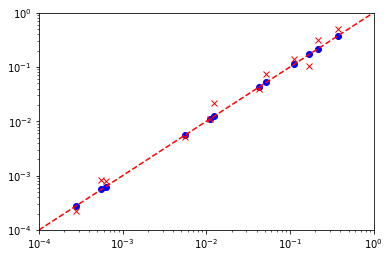

In [33]:
mol_lims = [1e-4,1]
plt.figure()
plt.loglog(mol_endmem, X, 'bo')
plt.loglog(mol_endmem, X_init, 'rx')
plt.plot(mol_lims, mol_lims, 'r--')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlim(mol_lims)
plt.ylim(mol_lims)

In [34]:
inds = np.argsort(mol_endmem)[::-1]

In [35]:

mol_pure = np.eye(mol_endmem.size)
mol_pure[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
'''
A, X = liq.affinity_and_comp(T, P, mu, X_init=mol_pure[inds[6]], ATOL=1e-3, XTOL=1e-4, iter_max=50, debug=True)
plt.figure()
plt.plot(mol_endmem, X, 'o')
plt.xlim(0,1)
plt.ylim(0,1)
np.max(X-mol_endmem)
'''

"\nA, X = liq.affinity_and_comp(T, P, mu, X_init=mol_pure[inds[6]], ATOL=1e-3, XTOL=1e-4, iter_max=50, debug=True)\nplt.figure()\nplt.plot(mol_endmem, X, 'o')\nplt.xlim(0,1)\nplt.ylim(0,1)\nnp.max(X-mol_endmem)\n"